# Assignment 3
## Training a neural named entity recognition (NER) tagger

In this assignment you are required to build a full training and testing pipeline for a neural sequentail tagger for named entities, using LSTM.



The dataset that you will be working on is called ReCoNLL 2003, which is a corrected version of the [CoNLL 2003 dataset](https://www.clips.uantwerpen.be/conll2003/ner/):

- [Train data](https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing)

- [Dev data](https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing)

- [Test data](https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing)

As you will see, the annotated texts are labeled according to the `IOB` annotation scheme, for 3 entity types: Person, Organization, Location.


NER schemes:

> `IO`: is the simplest scheme that can be applied to this task. In this scheme, each token from the dataset is assigned one of two tags: an inside tag (I) and an outside tag (O). The I tag is for named entities, whereas the O tag is for normal words. This scheme has a limitation, as it cannot correctly encode consecutive entities of the same type.

> **`IOB`: This scheme is also referred to in the literature as BIO and has been adopted by the Conference on Computational Natural Language Learning (CoNLL) [1]. It assigns a tag to each word in the text, determining whether it is the beginning (B) of a known named entity, inside (I) it, or outside (O) of any known named entities.**

> `IOE`: This scheme works nearly identically to IOB, but it indicates the end of the entity (E tag) instead of its beginning.

> `IOBES`: An alternative to the IOB scheme is IOBES, which increases the amount of information related to the boundaries of named entities. In addition to tagging words at the beginning (B), inside (I), end (E), and outside (O) of a named entity. It also labels single-token entities with the tag S.

> `BI`: This scheme tags entities in a similar method to IOB. Additionally, it labels the beginning of non-entity words with the tag B-O and the rest as I-O.

> `IE`: This scheme works exactly like IOE with the distinction that it labels the end of non-entity words with the tag E-O and the rest as I-O.

> `BIES`: This scheme encodes the entities similar to IOBES. In addition, it also encodes the non-entity words using the same method. It uses B-O to tag the beginning of non-entity words, I-O to tag the inside of non-entity words, and S-O for single non-entity tokens that exist between two entities.


As always, make sure all results are uploaded to CSVs (as well as printed to console) for your assignment to be fully graded.
<br>
<br>

---

<br>

All additional packages:

In [ ]:
# !pip install --q

All imports:
(You may add/change)

In [ ]:
# general
import warnings
from typing import List,Tuple
from collections import defaultdict
from tqdm import tqdm
import requests


# ML
import numpy as np
import pandas as pd

# visual
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
from torch import nn, Tensor
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torchtext

# metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay


set warnings filter to ignore:

In [ ]:
warnings.filterwarnings('ignore')

Set random SEEDs:

In [ ]:
SEED = 42

# Set the random seed for Python to SEED

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED);

Set GPU:

In [ ]:
# make sure you're using a GPU

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

Global parameters

In [ ]:
STUDENT_1_ID = '1'
STUDENT_2_ID = '2'

## Task 1:
Write a function for reading the data from a single file (of the ones that are provided above).
- The function recieves a filepath
- The funtion encodes every sentence individually using a pair of lists, one list contains the words and one list contains the tags.
- Each list pair will be added to a general list (data), which will be returned back from the function.

Example output:
```
[
  (['At','Trent','Bridge',':'],['O','B-LOC','I-LOC ','O']),
  ([...],[...]),
  ...
]
```

In [ ]:
def read_data(data_link: str) -> List[Tuple[List[str],List[str]]]:
    data = []
    words, labels  = [], []
    file = requests.get(data_link).content.decode().split('\n')

    for line in file:
        if line == '' and len(words) > 0:
            data.append((words, labels))
            words, labels = [], []
            continue
        if line == '':
            continue
        word, label = line.strip().split()
        words.append(word)
        labels.append(label)

    return data

train_link = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_train.txt'
dev_link   = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_dev.txt'
test_link  = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_test.txt'

train = read_data(train_link)
test = read_data(test_link)
dev = read_data(dev_link)

## Task 2:

The following Vocab class can be served as a dictionary that maps words and tags into Ids.
The UNK_TOKEN should be used for words that are not part of the training data.

In [ ]:
UNK_TOKEN = 1
class Vocab:
    def __init__(self, train: List[Tuple[List[str], List[str]]]):
        self.word2id = {"__unk__": UNK_TOKEN}
        self.id2word = {UNK_TOKEN: "__unk__"}
        self.n_words = 1

        # initilize based on train dataset
        z = set([sec for sentence in train for sec in sentence[1]])
        self.tag2id = {pos: i for i, pos in enumerate(z)}
        self.id2tag = {i: pos for i, pos in enumerate(z)}

    def index_tagged_sentence(self, sentence, is_train=True):
       words, tags = sentence
       return self.index_words(words, is_train), self.index_tags(tags)

    def index_tags(self, tags:List[str]) -> List[int]:
      tag_indexes = [self.tag2id[t] for t in tags]
      return tag_indexes

    def index_words(self, words:List[str], is_train: bool) -> List[int]:
      word_indexes = [self.index_word(w, is_train) for w in words]
      return word_indexes

    def index_word(self, w:str,is_train=True) -> int:
        if w not in self.word2id:
            if not is_train:
               return self.word2id['__unk__']
            self.word2id[w] = self.n_words
            self.id2word[self.n_words] = w
            self.n_words += 1
        return self.word2id[w]


# Testing - do not change
vcb = Vocab(train)
assert vcb.tag2id.keys() == {"O":0, "B-PER":1, "I-PER": 2, "B-LOC": 3, "I-LOC": 4, "B-ORG": 5, "I-ORG": 6}.keys()
del vcb

Write a function prepare_data that takes one of the [train, dev, test] and the Vocab instance, for converting each pair of (words,tags) to a pair of indexes.

Each pair should be added to data_sequences, which will be returned back from the function.

Note: Vocabulary is based only on the train set.

In [ ]:
vocab = Vocab(train)
def prepare_data(data, vocab, is_train=False):
    data_sequences = list(map(lambda sentence: vocab.index_tagged_sentence(sentence, is_train), data))
    return data_sequences, vocab

train_sequences, vocab = prepare_data(train, vocab, is_train=True)
dev_sequences, vocab = prepare_data(dev, vocab)
test_sequences, vocab = prepare_data(test, vocab)
PAD = len(vocab.word2id)

Print: how many OOV words are in the dev dataset?

In [ ]:
dev_oov = 0
for seq in dev_sequences:

   dev_oov += (np.array(seq[0])==vocab.word2id["__unk__"]).sum()
print(f"Number of OOV in Dev dataset: {dev_oov}")

Number of OOV in Dev dataset: 638


Print: how many OOV words are in the test dataset?

In [ ]:
test_oov = 0
for seq in test_sequences:
   test_oov += (np.array(seq[0])==vocab.word2id["__unk__"]).sum()
print(f"Number of OOV in Test dataset: {test_oov}")

Number of OOV in Test dataset: 1368


<br><br><br><br><br><br>

## Task 3:

Write NERNet, a PyTorch Module for labeling words with NER tags.

> `input_size`: the size of the vocabulary
`embedding_size`: the size of the embeddings
`hidden_size`: the LSTM hidden size
`output_size`: the number tags we are predicting for
`n_layers`: the number of layers we want to use in LSTM
`directions`: could 1 or 2, indicating unidirectional or bidirectional LSTM, respectively

<br>

The input for your forward function should be a single sentence tensor.

*Note: the embeddings in this section are learned embedding. That means that you don't need to use pretrained embedding like the one used in class. You will use them in part 5.*

*Note: You may change the NERNet class.*

In [ ]:
class NERNet(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers, directions):
        super(NERNet, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=PAD)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, bidirectional=(True if directions==2 else False), batch_first=True)
        self.out = nn.Linear(directions*hidden_size, output_size)

    def forward(self, input_sentence, samples_length):
        embedded_sentence = self.embedding(input_sentence)
        X = pack_padded_sequence(embedded_sentence, samples_length, batch_first=True)
        output, (hidden, cell) = self.lstm(X)
        output, _ = pad_packed_sequence(output, batch_first=True, padding_value=PAD)
        output = output.contiguous()
        output = output.view(-1, output.shape[2])
        output = self.out(output)
        return output


Create a Dataloader for the training phase

In [ ]:
def pad_data(batch: list):
    lengths = torch.tensor([len(sentence[0]) for sentence in batch], dtype=torch.int64)
    sorted_lengths, idx = lengths.sort(descending=True)
    x_batch = [torch.Tensor(t[0]).long() for t in batch]
    y_batch = [torch.Tensor(t[1]).long() for t in batch]
    x_batch = pad_sequence(x_batch, batch_first=True, padding_value=PAD)
    y_batch = pad_sequence(y_batch, batch_first=True, padding_value=PAD)
    x_batch = x_batch[idx]
    y_batch = y_batch[idx]
    return x_batch, y_batch, sorted_lengths

In [ ]:
def prepare_data_loader(sequences, batch_size):
  dataloader = DataLoader(sequences, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=pad_data)
  return dataloader


dl_train  = prepare_data_loader(train_sequences , batch_size = 64)
dl_dev    = prepare_data_loader(dev_sequences   , batch_size = 64)
dl_test   = prepare_data_loader(test_sequences  , batch_size = 64)

<br><br><br><br><br><br>

## Task 4:

Write a training loop, which takes a model (instance of NERNet), number of epochs to train on, and the train&dev datasets.

The function will return the `loss` and `accuracy` durring training.
(If you're using a different/additional metrics, return them too)

The loss is always CrossEntropyLoss and the optimizer is always Adam.
Make sure to use `tqdm` while iterating on `n_epochs`.


In [ ]:
def train_loop(model, n_epochs, dataloader_train, dataloader_dev, verbose=True):
  dataloaders = {"train": dataloader_train, "dev": dataloader_dev}
  # Loss function
  criterion = nn.CrossEntropyLoss(ignore_index=PAD)

  # Optimizer (ADAM is a fancy version of SGD)
  optimizer = Adam(model.parameters(), lr=0.01)

  # record
  metrics = {'loss':{'train':[], 'dev':[]}, 'accuracy':{'train':[], 'dev':[]} }

  for _ in tqdm(range(1, n_epochs + 1)):
    for phase in dataloaders.keys():
        if phase == 'train':
          model.train()  # Set model to training mode
        else:
          model.eval()
        running_loss = 0.0   # total loss of the network at each epoch
        running_corrects = 0
        words_count = 0
        for samples, labels, lengths in dataloaders[phase]:
          samples = samples.to(DEVICE)
          labels = labels.flatten().to(DEVICE)
          optimizer.zero_grad()
          output = model(samples, lengths)
          loss = criterion(output, labels)
          running_loss += loss.item()
          predicted = torch.argmax(output, 1)
          running_corrects += torch.sum(predicted[labels != PAD] == labels[labels != PAD]).item()
          words_count += labels[labels != PAD].shape[0]
          if phase == 'train':
            loss.backward()
            optimizer.step()
        epoch_loss = running_loss/ words_count
        epoch_accuracy = running_corrects/words_count
        metrics['loss'][phase].append(epoch_loss)
        metrics['accuracy'][phase].append(epoch_accuracy)

  return metrics

In [ ]:
model = NERNet(len(vocab.id2word)+2, 300, 500, len(vocab.id2tag), n_layers=1, directions=1).to(DEVICE)

In [ ]:
metrics = train_loop(model, 6, dl_train, dl_dev)

100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


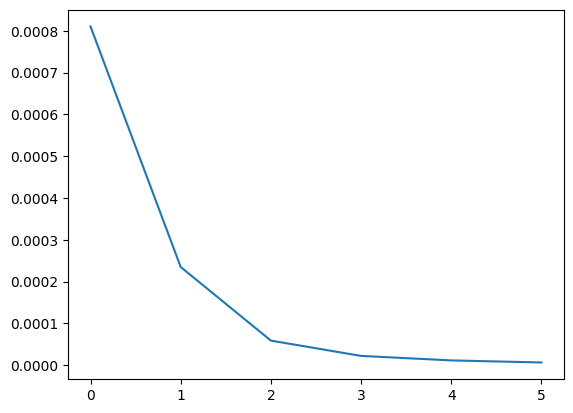

In [ ]:
plt.plot(metrics['loss']['train'])

<br><br><br><br><br><br>

## Task 5:
Write an evaluation loop on a trained model, using the dev and test datasets.
This function will print a `classification_report` and plot a `confusion matrix`.
Do this for each label seperately (7 labels in total), and add an calculation for all the 6 labels (except O) together.





Metrics:
- `Recall`: true positive rate (TPR), also known as Recall.
- `Percision`: the opposite to false positive rate (FPR), also known as precision.
- `F1 score`: harmonic average
- *For all these metries use **weighted**:
Calculate metrics for each label, and find their average weighted by support ([link](https://https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

To display:
1. Print a `classification_report` in a `tabulate` format (similar to assignment#2)
2. Display a `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Make sure to use the title for the plot, axis names, and the names of the tags on the X-axis.


In [ ]:
def evaluate(model: nn.Module, title, dataloader, verbose = False, matrix = False):
  with torch.no_grad():
    model.eval()
    total_labels = torch.empty(0, dtype=int)
    total_preds = torch.empty(0, dtype=int).to(DEVICE)
    for samples, labels, lengths in dataloader:
      total_labels = torch.cat([total_labels, labels.flatten()])
      output = model(samples.to(DEVICE), lengths)
      total_preds = torch.cat([total_preds,  torch.argmax(output, 1)])
  total_preds = total_preds[total_labels!=PAD]
  total_labels = total_labels[total_labels!=PAD]
  all_precision, all_recall, all_f1_score, _ = precision_recall_fscore_support(total_labels, total_preds.to('cpu'),
                                                                  average='weighted', labels=total_labels.unique(), zero_division=0)
  precision, recall, f1_score, _  = precision_recall_fscore_support(total_labels, total_preds.to('cpu'),
                                                                  average= 'weighted', labels=total_labels.unique()[~(total_labels.unique()==vocab.tag2id['O'])], zero_division=0)
  columns = ['RECALL','PERCISION','F1','RECALL_WO_O','PERCISION_WO_O','F1_WO_O']
  data = [all_recall, all_precision, all_f1_score, recall, precision, f1_score]
  if verbose:
    print(tabulate(pd.DataFrame(data=[data], columns=columns), headers='keys', tablefmt='psql'))
  if matrix:
    fig, axes = plt.subplots(1,2, figsize=(11,6))
    o_idx = list(vocab.tag2id.keys()).index('O')
    cm = confusion_matrix(total_labels, total_preds.to('cpu'), labels=total_labels.unique())
    cm_wo_o = np.delete(np.delete(cm, o_idx, 1), o_idx, 0)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vocab.tag2id.keys())
    disp_wo_o = ConfusionMatrixDisplay(confusion_matrix=cm_wo_o, display_labels=[tag for tag in vocab.tag2id.keys() if tag != 'O'])
    disp.plot(ax=axes[0], colorbar=False)
    disp_wo_o.plot(ax=axes[1], colorbar=False)
    disp.ax_.set_title('With O')
    disp_wo_o.ax_.set_title('Without O')
    fig.suptitle(title, size=16)
    fig.tight_layout()
  return data

+----+----------+-------------+----------+---------------+------------------+-----------+
|    |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|----+----------+-------------+----------+---------------+------------------+-----------|
|  0 | 0.913771 |    0.918119 | 0.911789 |      0.688312 |         0.815786 |  0.733519 |
+----+----------+-------------+----------+---------------+------------------+-----------+


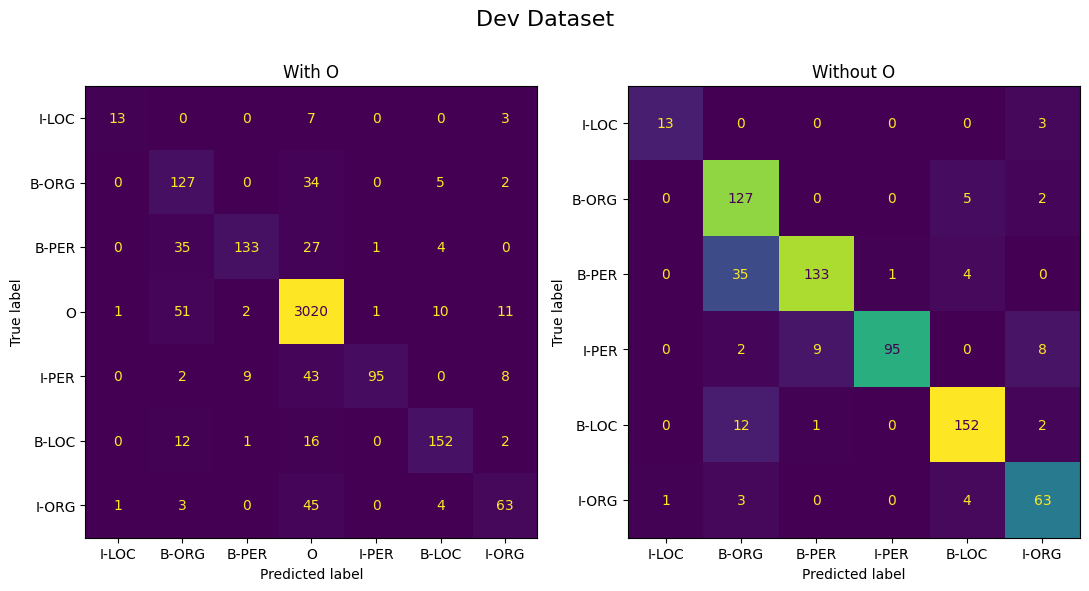

In [ ]:
dev_data = evaluate(model,"Dev Dataset", dl_dev, verbose=True, matrix=True)

+----+----------+-------------+----------+---------------+------------------+-----------+
|    |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|----+----------+-------------+----------+---------------+------------------+-----------|
|  0 | 0.924299 |    0.929618 | 0.924383 |      0.735084 |         0.799163 |   0.75455 |
+----+----------+-------------+----------+---------------+------------------+-----------+


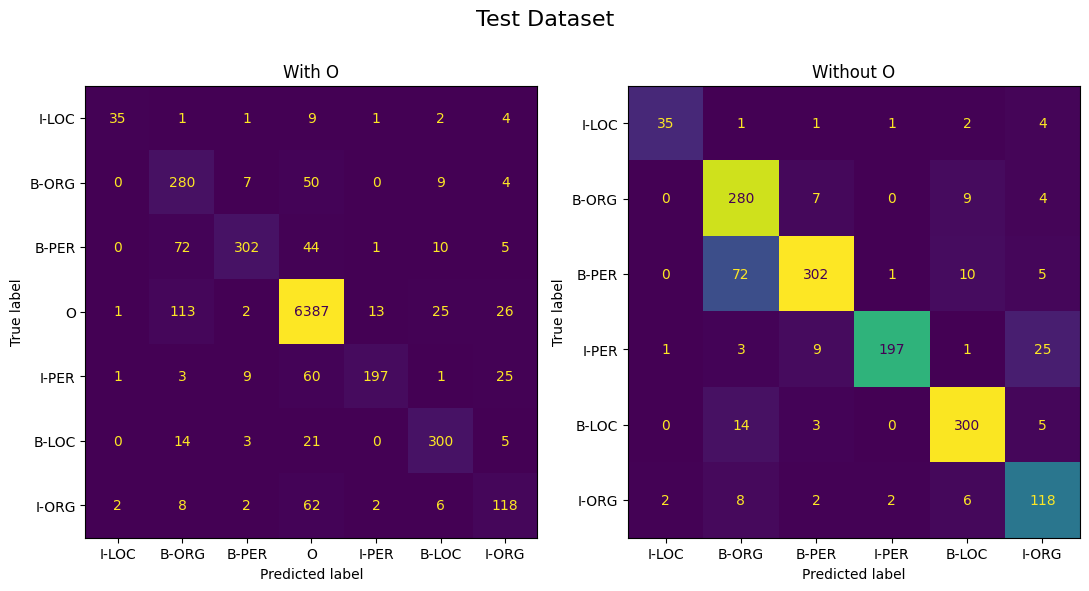

In [ ]:
test_Data = evaluate(model,"Test Dataset", dl_test, verbose=True, matrix=True)

<br><br><br><br><br><br>

## Task 6:

Reset all seeds to 42.

In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED);

Train and evaluate a few models, all with `embedding_size=300`, and with the following hyper parameters (you may use that as captions for the models as well):

- Model 1: (hidden_size: 500, n_layers: 1, directions: 1)
- Model 2: (hidden_size: 500, n_layers: 2, directions: 1)
- Model 3: (hidden_size: 500, n_layers: 3, directions: 1)
- Model 4: (hidden_size: 500, n_layers: 1, directions: 2)
- Model 5: (hidden_size: 500, n_layers: 2, directions: 2)
- Model 6: (hidden_size: 500, n_layers: 3, directions: 2)
- Model 7: (hidden_size: 800, n_layers: 1, directions: 2)
- Model 8: (hidden_size: 800, n_layers: 2, directions: 2)
- Model 9: (hidden_size: 800, n_layers: 3, directions: 2)




Training model_1...


100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Training model_2...


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Training model_3...


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Training model_4...


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Training model_5...


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Training model_6...


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Training model_7...


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Training model_8...


100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


Training model_9...


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


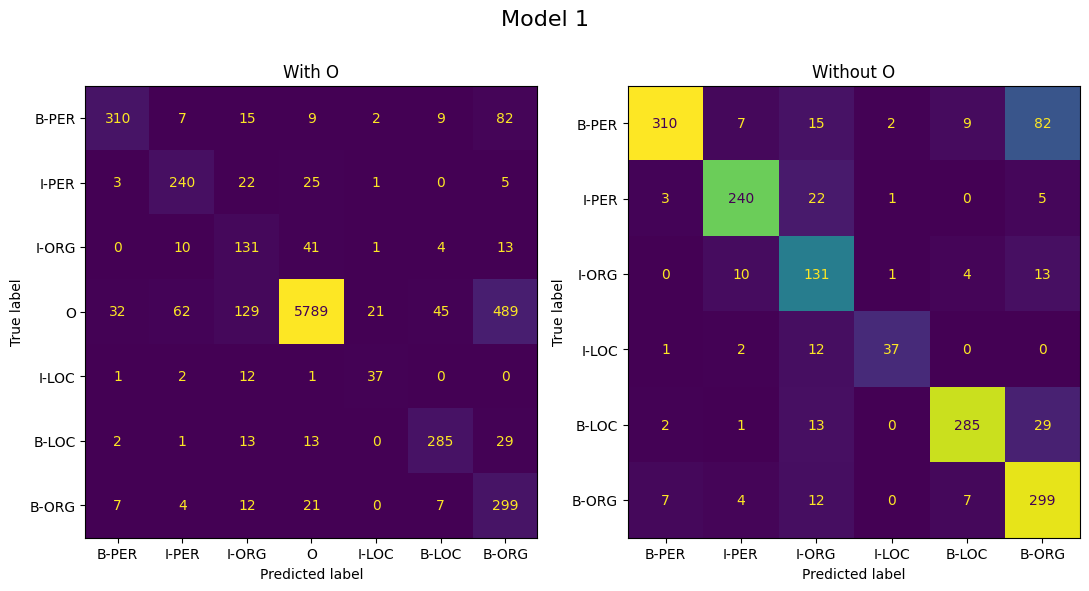

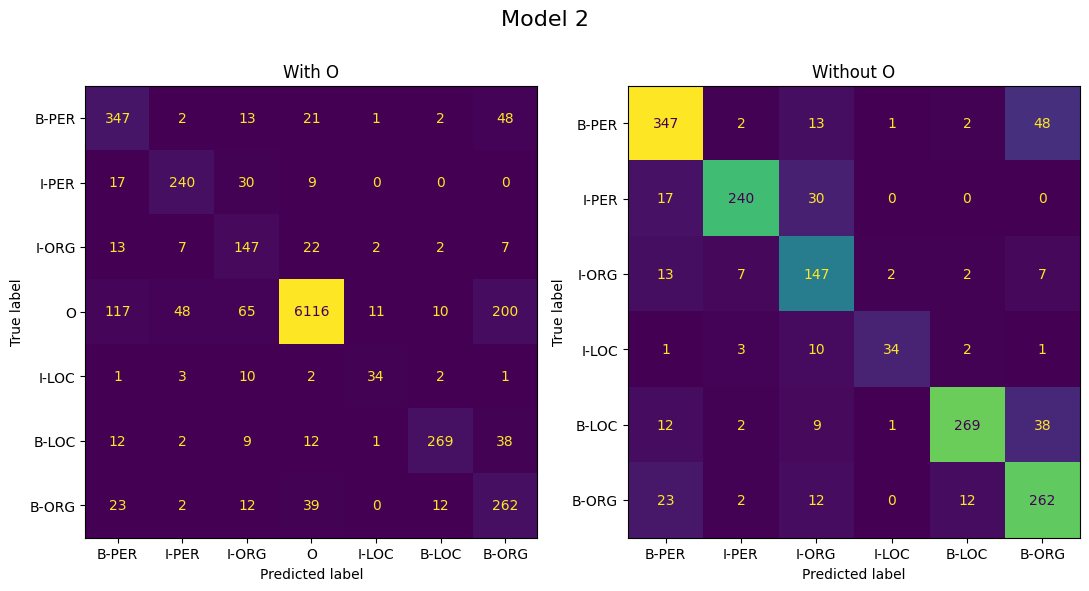

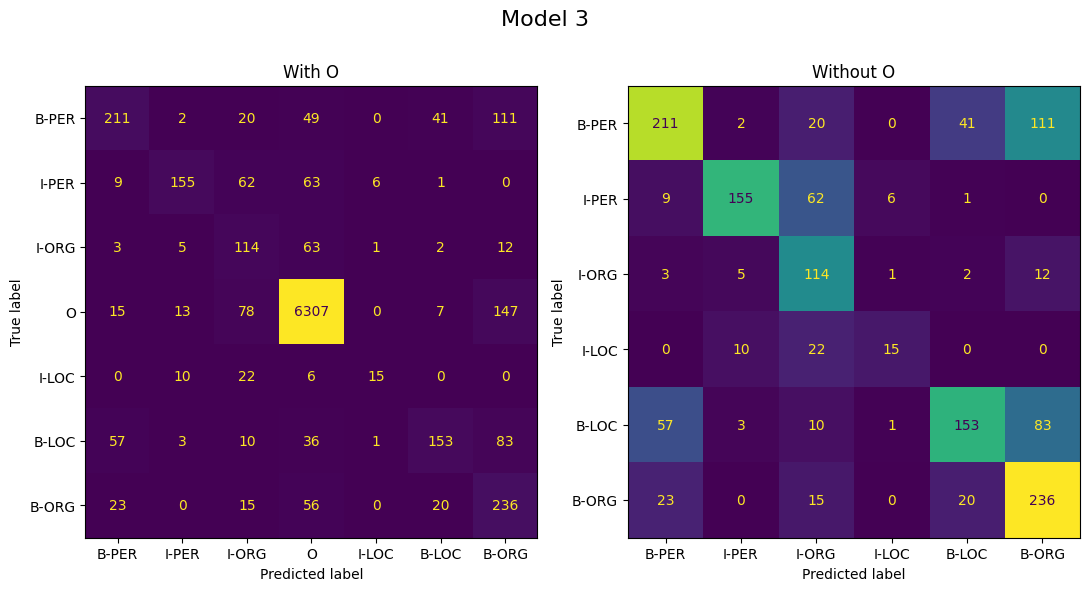

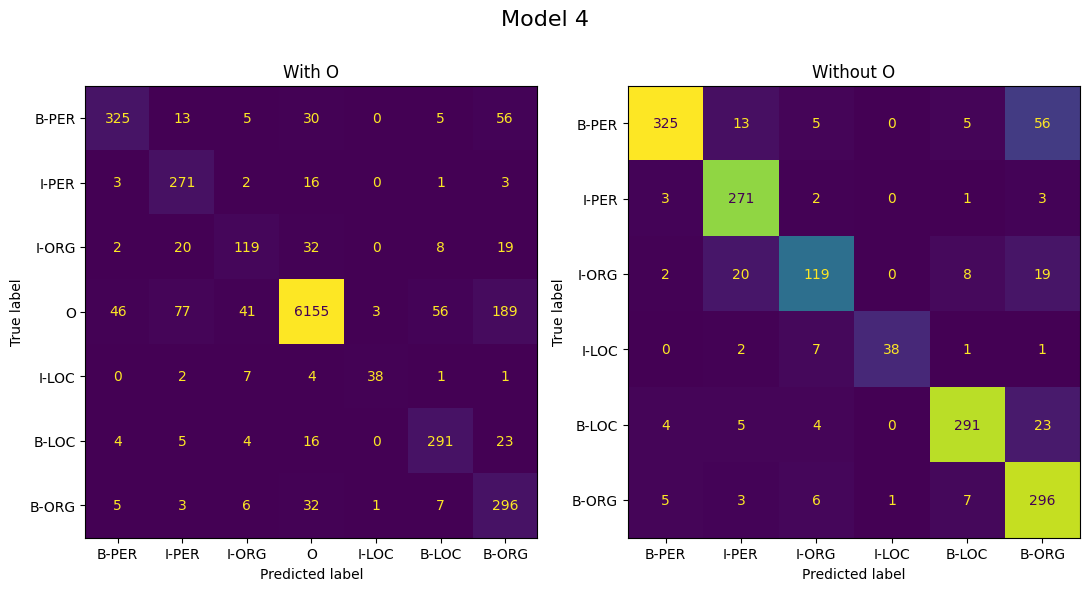

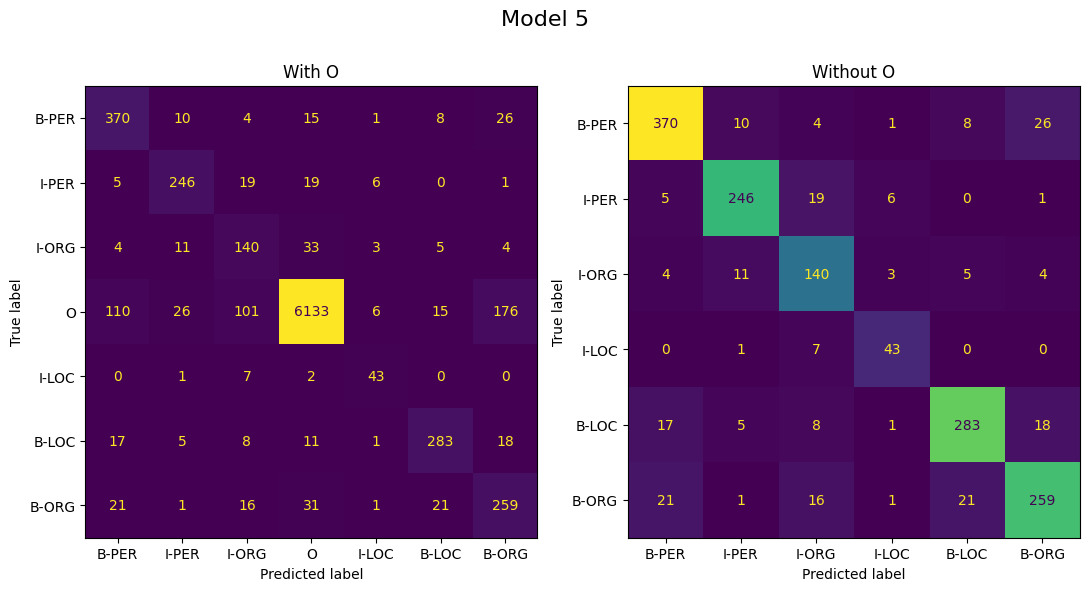

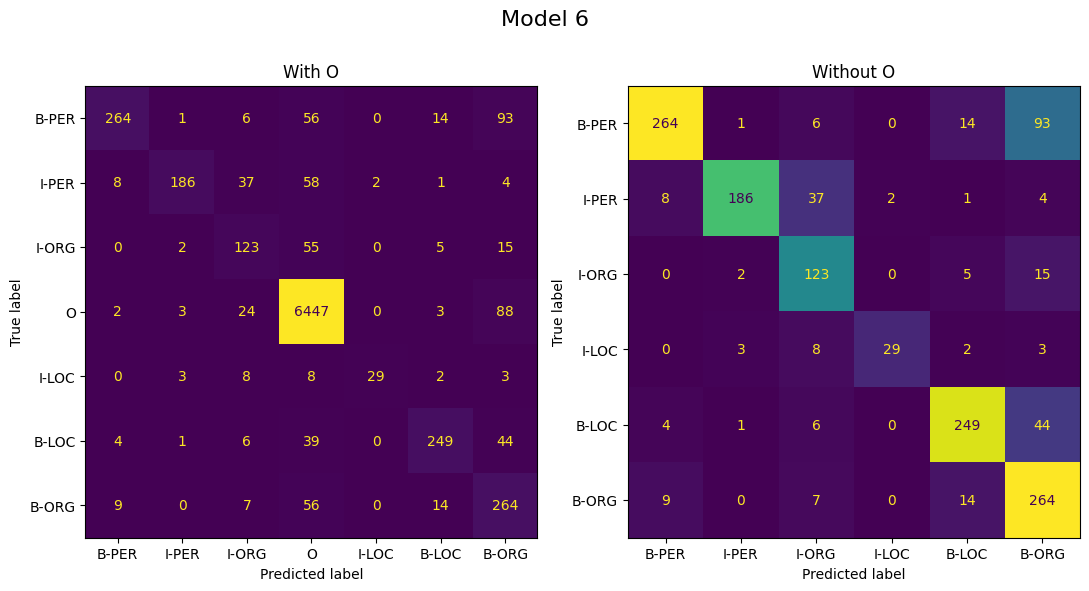

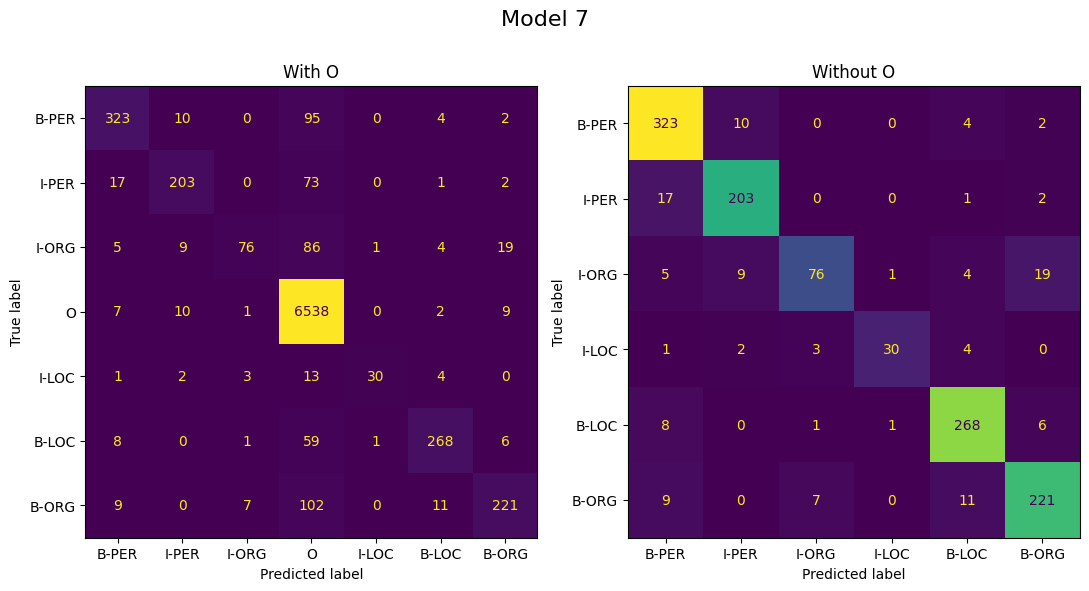

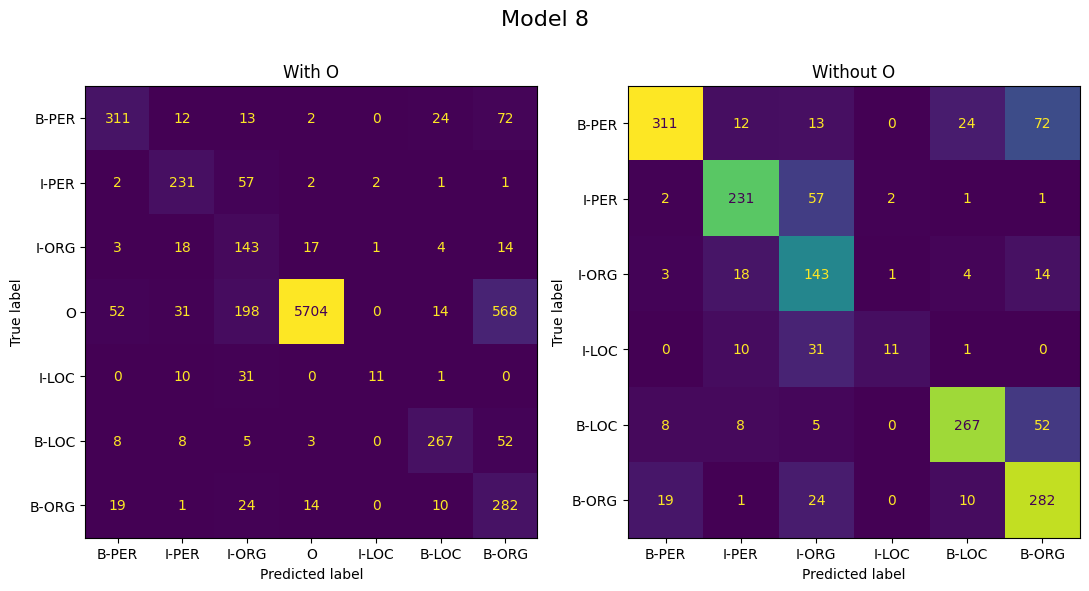

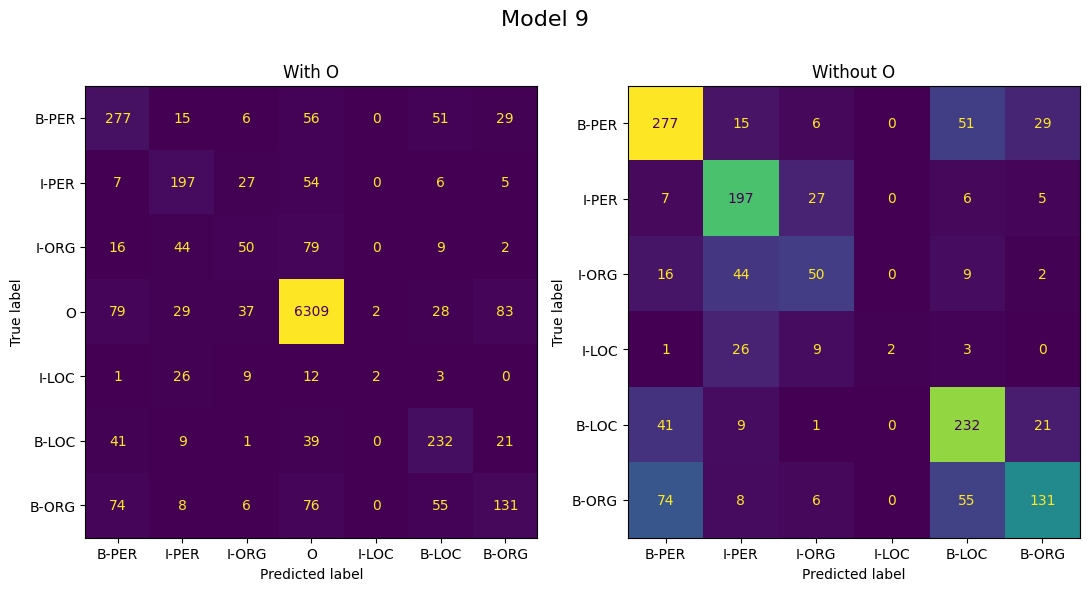

In [ ]:
columns = ['N_MODEL','HIDDEN_SIZE','N_LAYERS','DIRECTIONS','RECALL','PERCISION','F1','RECALL_WO_O','PERCISION_WO_O','F1_WO_O']
models = {
    'Model1': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 1},
    'Model2': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 1},
    'Model3': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 1},
    'Model4': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 2},
    'Model5': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 2},
    'Model6': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 2},
    'Model7': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 1, 'directions': 2},
    'Model8': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 2, 'directions': 2},
    'Model9': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 3, 'directions': 2},
}

results_df = pd.DataFrame()
for i, model_params in enumerate(models.values(), 1):
    model = NERNet(len(vocab.id2word)+2, model_params['embedding_size'], model_params['hidden_size'], len(vocab.id2tag), n_layers=model_params['n_layers'], directions=model_params['directions']).to(DEVICE)
    print(f"Training model_{i}...")
    metrics = train_loop(model, 10, dl_train, dl_dev, verbose=False)
    data = evaluate(model, f"Model {i}", dl_test, matrix=True)
    result_df = pd.DataFrame([[f'model_{i}', model_params['hidden_size'], model_params['n_layers'], model_params['directions']] + data], columns=columns)
    results_df = pd.concat([results_df, result_df])

**Save CSV**
In addition, for each model use the `test` dataset and check the model metrics.

> Metrics:
1. `RECALL`, `PERCISION`,`F1` - for all tags
2. `RECALL_WO_O`,`PERCISION_WO_O`,`F1_WO_O` - for all tags **without** the O tag.
3. *For all these metries use **weighted** ([link](https://https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

> - Save the results in a CSV
`{student_id_1}_{student_id_n}_part6.csv`
For example: `300123123_200456789_part_6.csv`

> - Print the results as follows:  (results here are random)

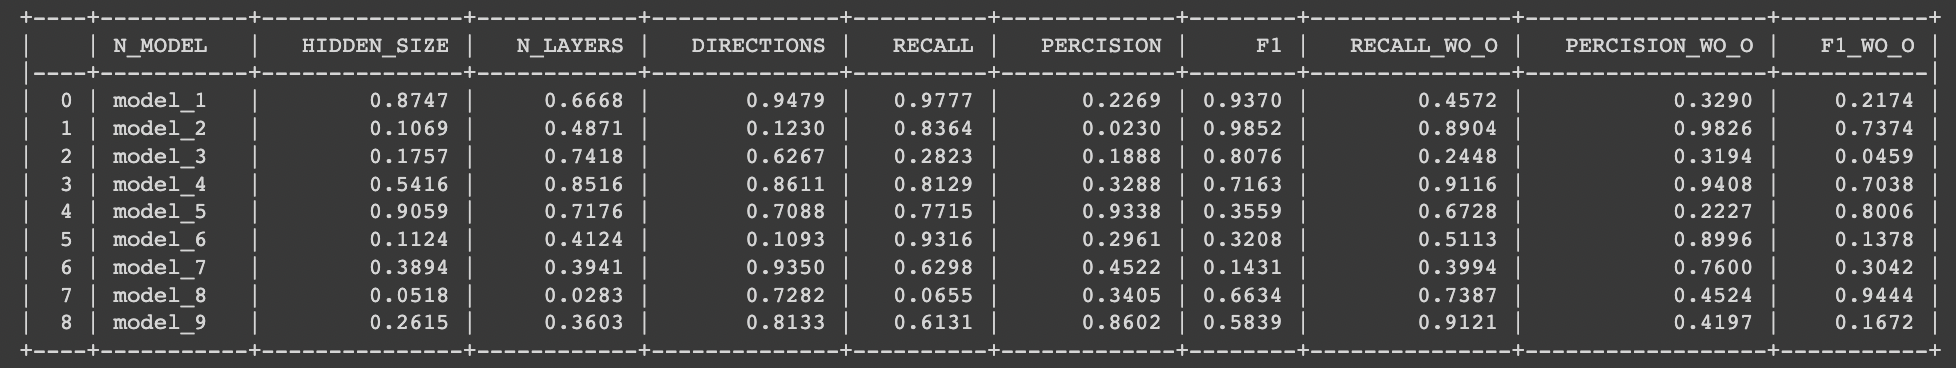

In [ ]:
results_df.to_csv(f"{STUDENT_1_ID}_{STUDENT_2_ID}_part6.csv")
print(tabulate(results_df, headers='keys', tablefmt='psql'))

+----+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------+
|    | N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|----+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------|
|  0 | model_1   |           500 |          1 |            1 | 0.860245 |    0.915315 | 0.879318 |      0.77685  |         0.65656  |  0.685567 |
|  0 | model_2   |           500 |          2 |            1 | 0.899551 |    0.920679 | 0.90717  |      0.77506  |         0.676012 |  0.713799 |
|  0 | model_3   |           500 |          3 |            1 | 0.872377 |    0.886408 | 0.873879 |      0.527446 |         0.603892 |  0.538558 |
|  0 | model_4   |           500 |          1 |            2 | 0.909256 |    0.925267 | 0.914217 |      0.799523 |         0

<br><br><br><br><br>

## Task 7:

Reset all seeds to 42.

In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED);


In preparation for this task you should read [this](https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222) dicussion.

*TIP: make sure that vectors are aligned with the IDs in your Vocab, in other words, make sure that for example the word with ID 0 is the first vector in the GloVe matrix of vectors that you initialize nn.Embedding with.*

---


Download the GloVe embeddings from https://nlp.stanford.edu/projects/glove/ (use the 300-dim vectors from glove.6B.zip).


In [ ]:
glove = torchtext.vocab.GloVe('6B')
glove.dim

300

In [ ]:
glove.vectors = torch.cat([glove.vectors, glove['__unk__'].unsqueeze(0)], 0)
glove_idxs = {k: glove.stoi.get(k.lower(), -1) for k in vocab.word2id}
glove_idxs["PAD"] = -1
embedding_vectors = glove.vectors[list(glove_idxs.values())]

Then intialize the `nn.Embedding` module in your `NERNet` with these embeddings, so that you can start your training with pre-trained vectors.

Repeat `Task 6`

Training model_0...


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Training model_1...


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Training model_2...


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Training model_3...


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Training model_4...


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Training model_5...


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


Training model_6...


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Training model_7...


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


Training model_8...


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


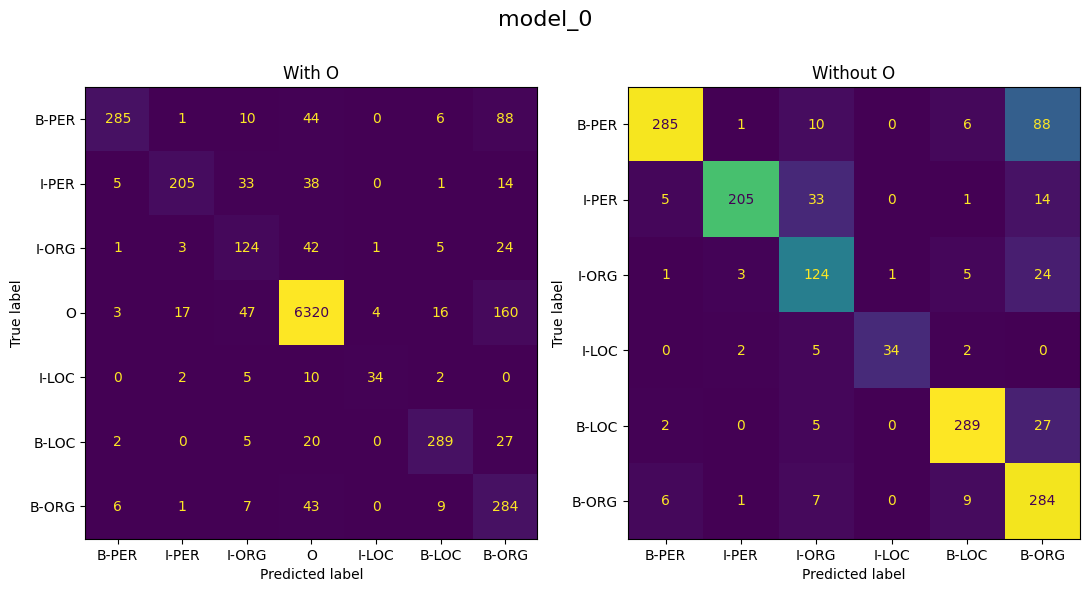

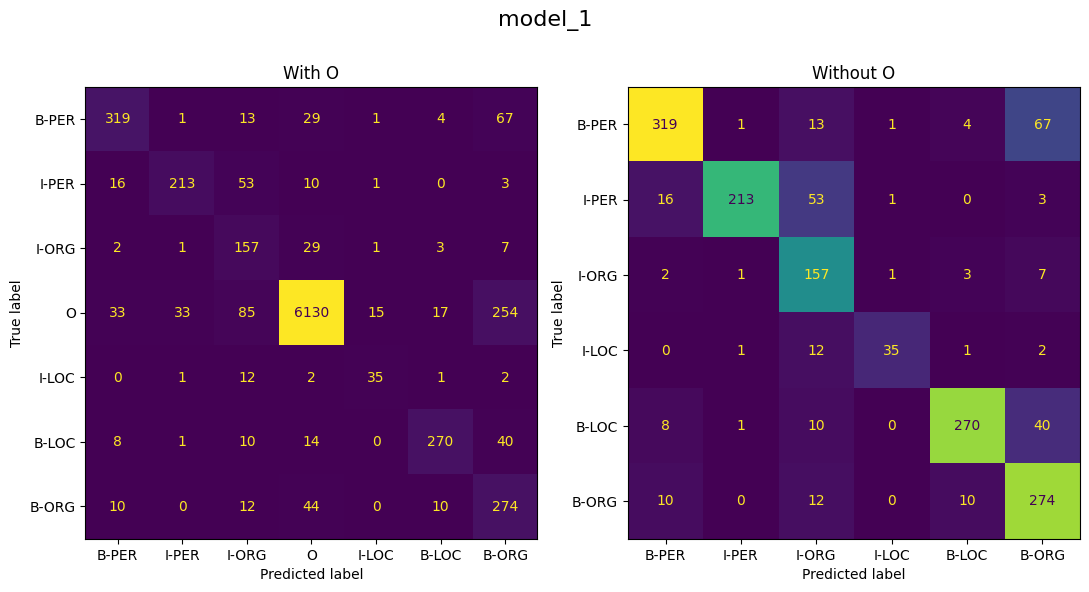

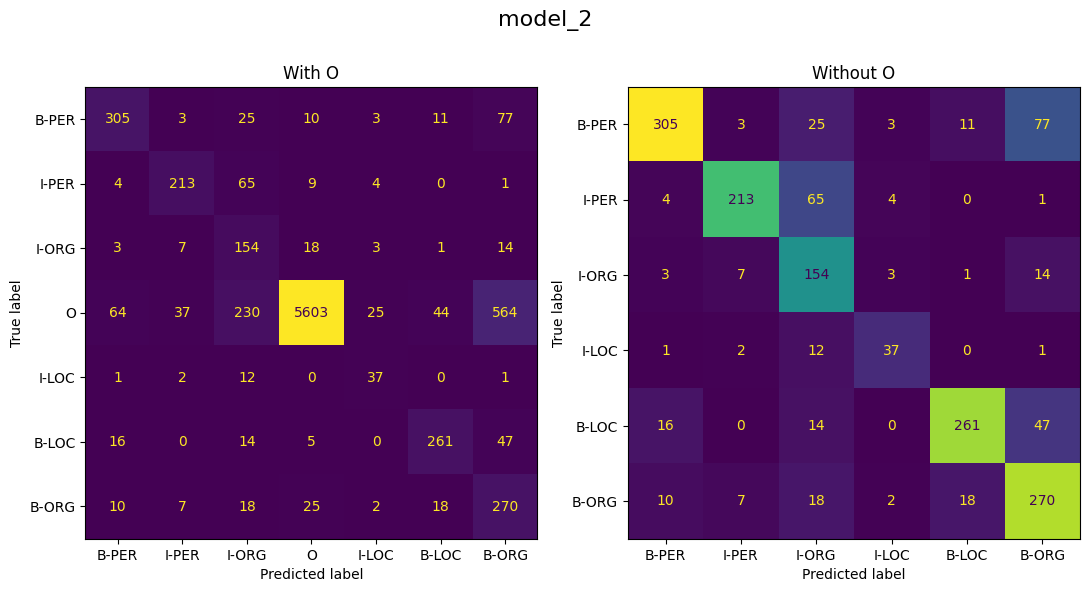

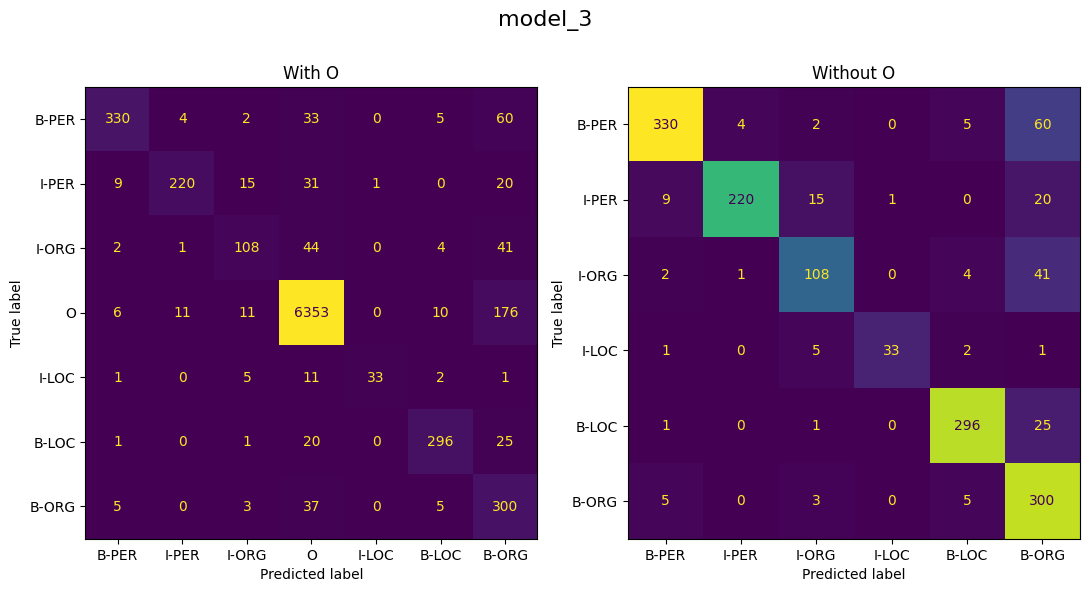

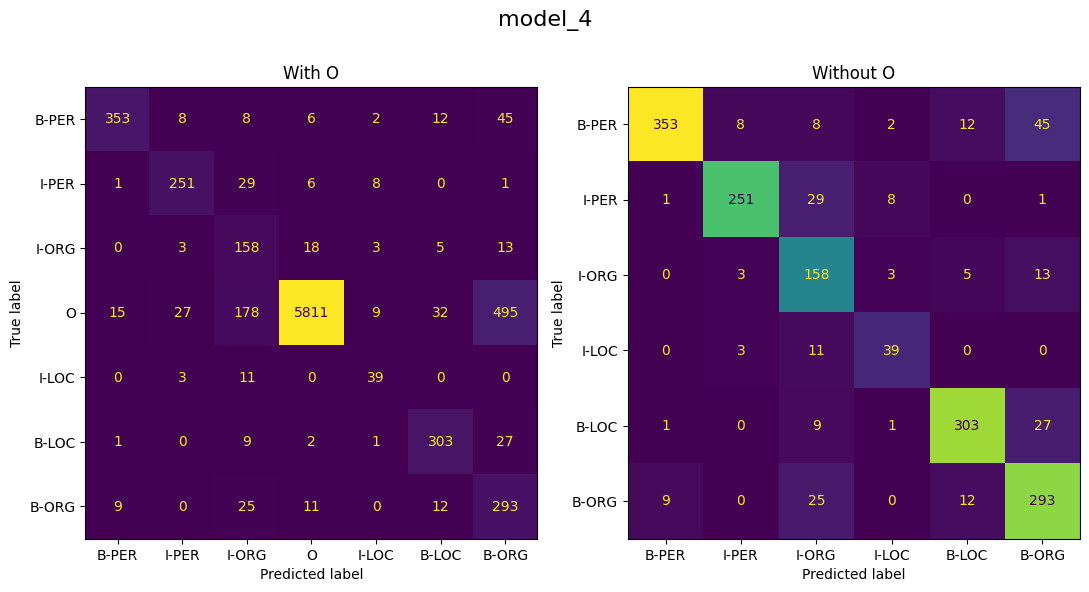

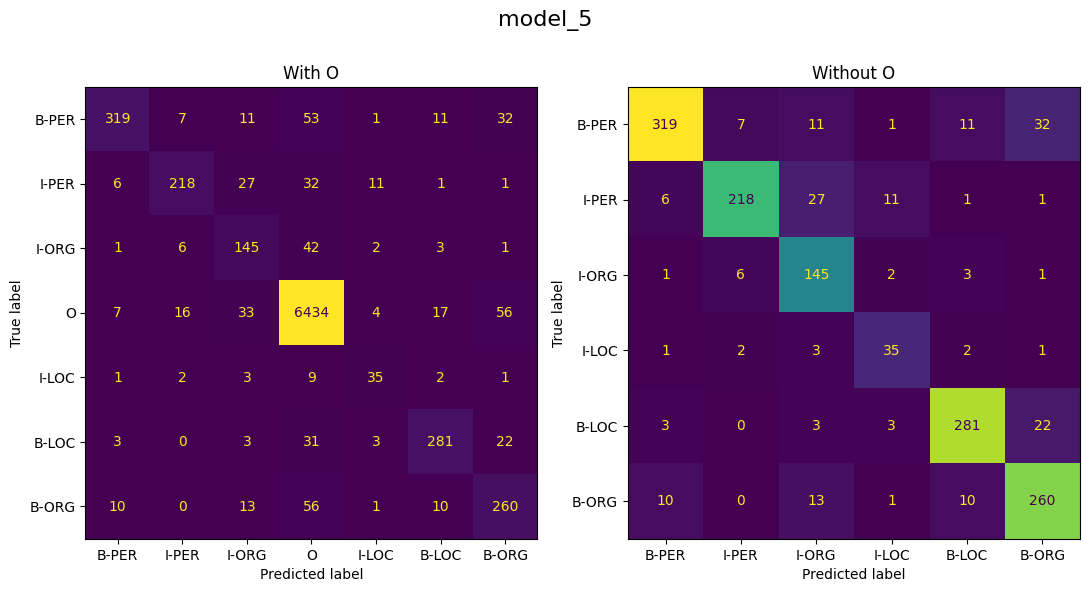

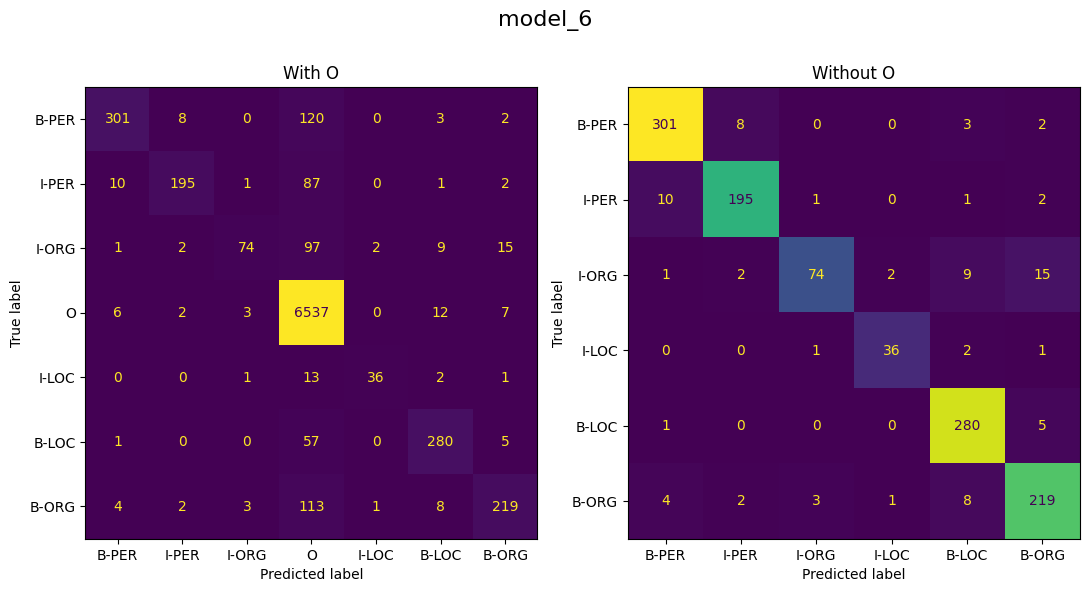

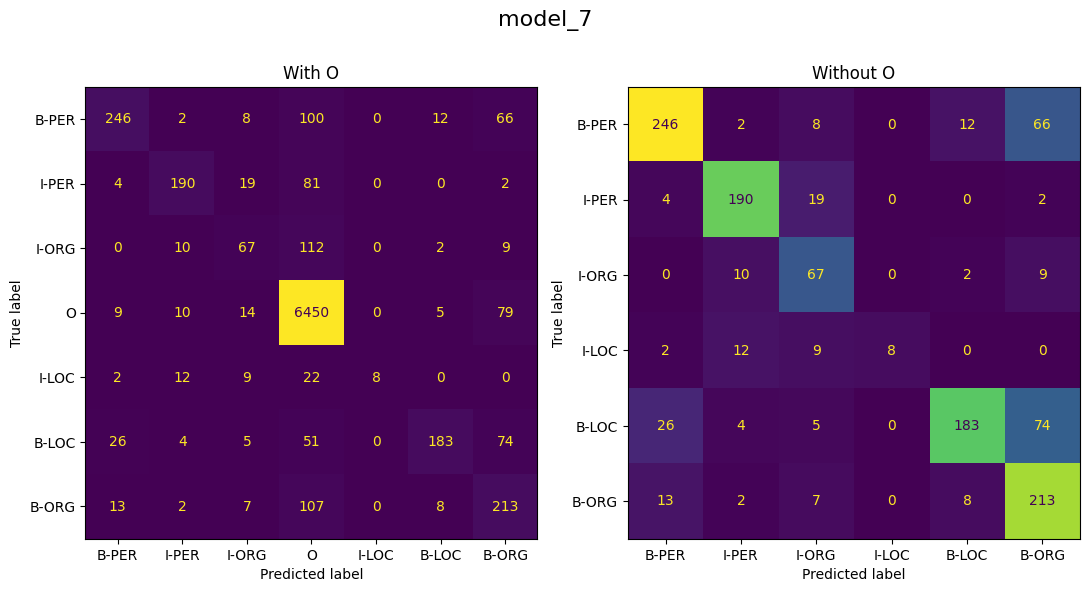

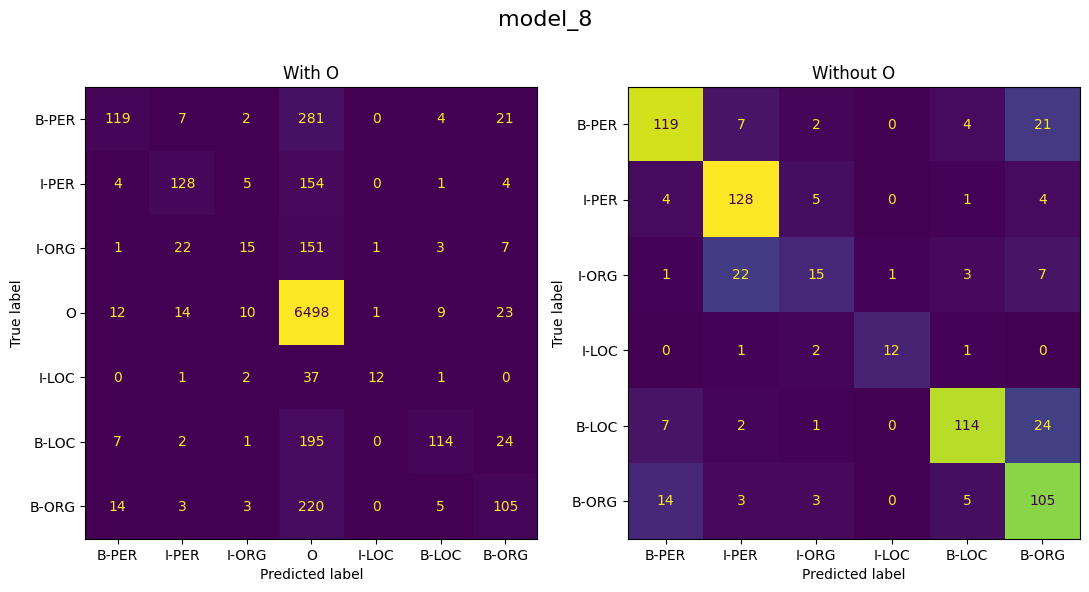

In [ ]:
glove_results_df = pd.DataFrame()
for i, model_params in enumerate(models.values()):
    model = NERNet(len(vocab.id2word)+2, model_params['embedding_size'], model_params['hidden_size'], len(vocab.id2tag), n_layers=model_params['n_layers'], directions=model_params['directions']).to(DEVICE)
    model.embedding.from_pretrained(embedding_vectors, padding_idx=PAD)
    print(f"Training model_{i}...")
    metrics = train_loop(model, 10, dl_train, dl_dev, verbose=False)
    data = evaluate(model, f'model_{i}', dl_test, matrix=True)
    result_df = pd.DataFrame([[f'model_{i}', model_params['hidden_size'], model_params['n_layers'], model_params['directions']] + data], columns=columns)
    glove_results_df = pd.concat([glove_results_df, result_df])

Same as `Task 6`, please display:

1. Print a `classification_report` in a tabulate format.
2. Display a `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Make sure to use the title for the plot, axis names, and the names of the tags on the X-axis.

- Save the results in a CSV {student_id_1}_{student_id_n}_part7.csv
For example: 300123123_200456789_part_7.csv

- Print the results as follows:

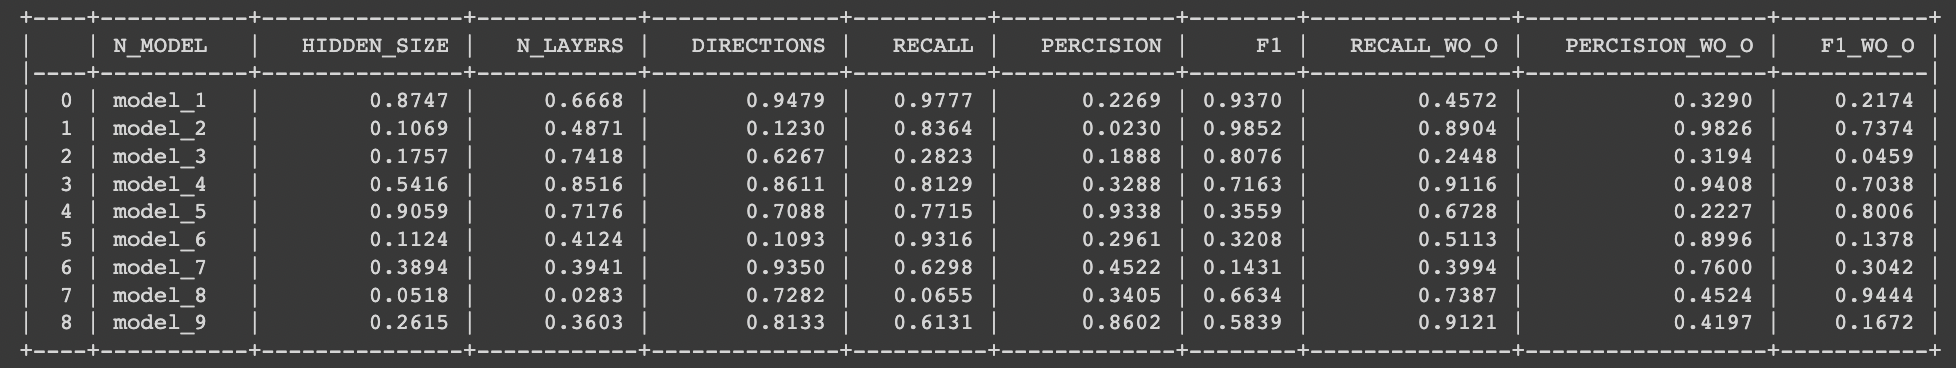

In [ ]:
glove_results_df.to_csv(f"{STUDENT_1_ID}_{STUDENT_2_ID}_part7.csv")
print(tabulate(glove_results_df, headers='keys', tablefmt='psql'))

+----+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------+
|    | N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|----+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------|
|  0 | model_0   |           500 |          1 |            1 | 0.914837 |    0.929918 | 0.918485 |      0.72852  |         0.773764 |  0.732051 |
|  0 | model_1   |           500 |          2 |            1 | 0.897489 |    0.924465 | 0.906778 |      0.756563 |         0.708643 |  0.714125 |
|  0 | model_2   |           500 |          3 |            1 | 0.830159 |    0.910161 | 0.858509 |      0.739857 |         0.604448 |  0.634236 |
|  0 | model_3   |           500 |          1 |            2 | 0.926847 |    0.940766 | 0.930043 |      0.7679   |         0

<br><br><br><br><br><br>
**Good luck!**